In [1]:
from scipy.fft import fft, ifft, fftshift, ifftshift
import numpy as np
import matplotlib.pyplot as plt
from math import pi
plt.rcParams.update({'font.size': 22,'lines.linewidth': 2})

In [2]:
# numerical second derivative - assume 0 boundary so we can roll values
def func(psi,h):
    return 1j*(np.roll(psi,1)+np.roll(psi,-1)-2*psi)/(2*h**2)

# exact solution to the problem
def Exact_Solution(x,t,k0,s0):
    Den = s0**2+1j*t/2
    Const = (s0**2/(2*pi* (Den)**2 ))**(.25)
    Exp = np.exp(-x**2/(4*Den) + 1j*(s0**2*k0/(Den))*(x-k0*t/2))
    return Const*Exp

# timestep method given in associated paper
def D2rk4(U0,h,dt,Tmax):
    Times = np.arange(0,Tmax+dt,dt)
    U = np.zeros((len(U0),len(Times)),dtype=complex)
    U[:,0] = U0
    for j in range(len(Times)-1):
        # RK4
        k1 = func(U[:,j],h)
        k2 = func(U[:,j]+dt*k1/2,h)
        k3 = func(U[:,j]+dt*k2/2,h)
        k4 = func(U[:,j]+dt*k3,h)
        U[:,j+1] = U[:,j]+dt*(k1+2*k2+2*k3+k4)/6
    return U

# spectral method
def Fourier_Schrodinger(U0,Nx,Tvec,L=40/2/pi,dt=.0001):
    U = np.zeros((len(U0),len(Tvec)),dtype=complex)
    U[:,0] = U0
    Uhat = fftshift(fft(U0))
    # pre compute func
    difreq2 = -1j/2 * np.arange(-Nx//2,Nx//2)**2/L**2 # -i * xi^2/2
    for j in range(len(Tvec)-1):
#         Uhat = Uhat * np.exp(-1j*freq**2 *(Tvec[j+1]-Tvec[j])/2)
        # swap with numerical integrator out of curiousity
        for _ in range( round((Tvec[j+1]-Tvec[j])/dt) ):
            k1 = difreq2*Uhat
            k2 = difreq2*(Uhat+k1*dt/2)
            k3 = difreq2*(Uhat+k2*dt/2)
            k4 = difreq2*(Uhat+k3*dt)
            Uhat = Uhat + dt*(k1+2*k2+2*k3+k4)/6
        U[:,j+1] = ifft(ifftshift(Uhat))
    return U

# initial conditions of pde
def Initial_Conditions(x,k0,s0):
    return (2*pi*s0**2)**(-.25) * np.exp(-(x/2/s0)**2+1j*k0*x)


# numerical integrator for L2 norm (squared)
# just Riemann sums - matches trapezoidal w/ zero endpoints
def Square_L2(Data,h):
    Vals = np.abs(Data)**2
    return np.sum(Vals)*h

t = 0.00,    L2 Spectral = 0.99951,    L2 D2RK4 = 0.99951
t = 0.08,    L2 Spectral = 0.99951,    L2 D2RK4 = 0.99951
t = 0.16,    L2 Spectral = 0.99951,    L2 D2RK4 = 0.99951
t = 0.24,    L2 Spectral = 0.99951,    L2 D2RK4 = 0.99951
t = 0.32,    L2 Spectral = 0.99951,    L2 D2RK4 = 0.99951
t = 0.40,    L2 Spectral = 0.99951,    L2 D2RK4 = 0.99951

t = 0.00,    L2 Spectral = 0.99544,    L2 D2RK4 = 0.99544
t = 0.08,    L2 Spectral = 0.99544,    L2 D2RK4 = 0.99544
t = 0.16,    L2 Spectral = 0.99544,    L2 D2RK4 = 0.99544
t = 0.24,    L2 Spectral = 0.99544,    L2 D2RK4 = 0.99544
t = 0.32,    L2 Spectral = 0.99544,    L2 D2RK4 = 0.99544
t = 0.40,    L2 Spectral = 0.99544,    L2 D2RK4 = 0.99544



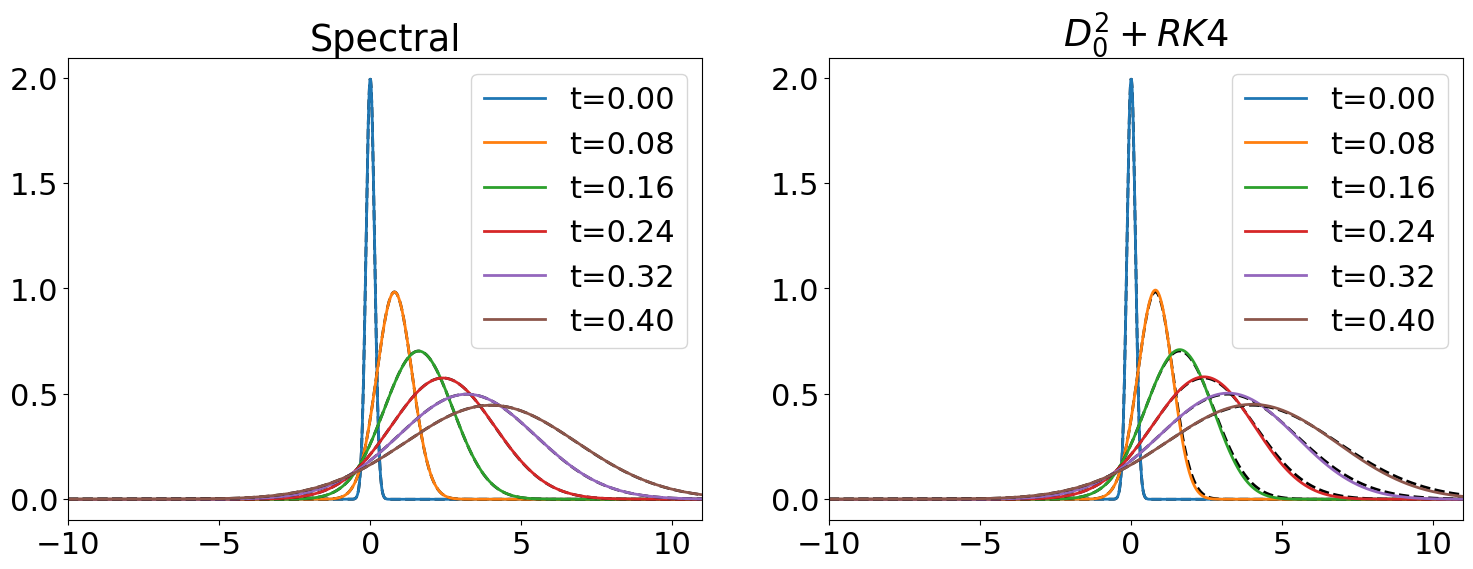

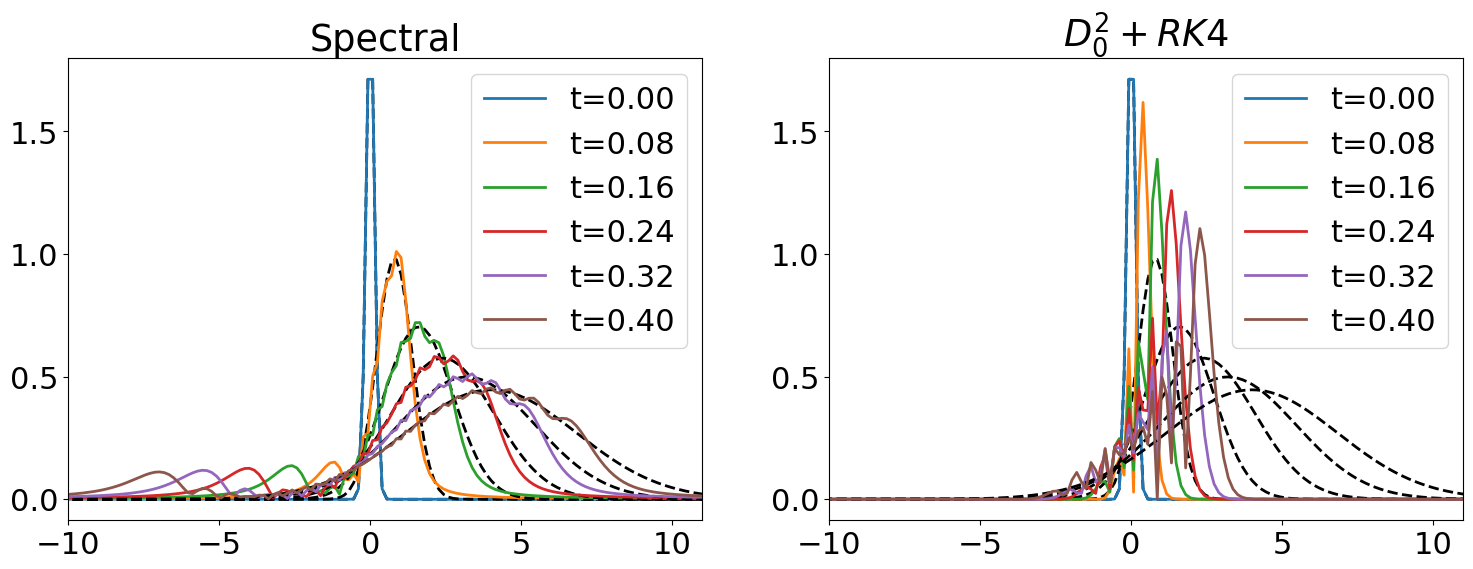

In [5]:
# params
k0 = 10
s0 = 0.1
Tmax = 0.4
Tvec = np.array([j*Tmax/5 for j in range(6)])

for Nx in [2048,256]:
    # space params
    h  = 40/Nx
    x  = np.linspace(-20,20,Nx)
    u0 = Initial_Conditions(x,k0,s0)
    
    # setup plot
    fig,ax = plt.subplots(1,2,figsize=(18,6))

    # numerical methods
    dt = .01*h**2 # needs to be small
    Spectral = np.abs(Fourier_Schrodinger(u0,Nx,Tvec,40/2/pi,dt))
    RungeKutta = np.abs(D2rk4(u0,h,dt,Tmax))
    
    # print (square of) L2 norm to check conservation
    for j in range(6):
        print('t = {:.2f},    L2 Spectral = {:.5f},    L2 D2RK4 = {:.5f}'.format(Tvec[j],\
                                        Square_L2(Spectral[:,j],h),Square_L2(RungeKutta[:,round(Tmax*j/5/dt)],h)))
    print()

    # plot results
    handles = [_ for _ in range(6)] # for legend
    for j in range(5+1):
        Exact = np.abs(Exact_Solution(x,Tvec[j],k0,s0))
        ax[0].plot(x,Exact,'k--')
        ax[1].plot(x,Exact,'k--')
        handles[j], = ax[0].plot(x,Spectral[:,j],label="t={:.2f}".format(Tvec[j]))
        ax[1].plot(x,RungeKutta[:,round(Tmax*j/5/dt)])
    ax[0].legend(handles=handles)  
    ax[0].set_xlim([-10, 11])
    ax[0].set_title('Spectral')
    ax[1].legend(handles=handles)  
    ax[1].set_xlim([-10, 11])
    ax[1].set_title(r'$D_0^2+RK4$')

    plt.savefig("Sch_{}.pdf".format(Nx))